# Extracting a Time Series

## **Overview**

In this tutorial, we will take MODIS Vegetation Indices Version 6.1 data which are generated every 16 days at 250 meter (m) spatial resolution for 2020 year to get the Normalised Differnece Vegetation Index (NDVI) at different point locations.

Data Credit:

*   Didan, K. (2015). MOD13Q1 MODIS/Terra Vegetation Indices 16-Day L3 Global 250m SIN Grid V061. NASA EOSDIS Land Processes DAAC. Accessed 2023-05 from https://doi.org/10.5067/MODIS/MOD13Q1.006




## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [247]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas
    !pip install rioxarray

In [248]:
import datetime
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import zipfile

In [249]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [250]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


filename = 'modis_vegetation_indices_2020.zip'
url = 'https://storage.googleapis.com/spatialthoughts-public-data/' + filename

download(url)

# Data Pre-Processing

First we unzip and extract the images to a folder.

In [251]:
zipfile_path = os.path.join(data_folder, filename)
with zipfile.ZipFile(zipfile_path) as zf:
  zf.extractall(data_folder)

In [252]:
def path_to_datetimeindex(filepath):
  filename = os.path.basename(filepath)
  pattern = r'doy(\d+)'
  match = re.search(pattern, filepath)
  if match:
      doy_value = match.group(1)
      timestamp = datetime.datetime.strptime(doy_value, '%Y%j')
      return timestamp
  else:
    print('Could not extract DOY from filename', filename)


timestamps = []
filepaths = []

files = os.path.join(data_folder, 'modis_vegetation_indices_2020', '*.tif')
for filepath in glob.glob(files):
  timestamp = path_to_datetimeindex(filepath)
  filepaths.append(filepath)
  timestamps.append(timestamp)

unique_timestamps = sorted(set(timestamps))

In [253]:
scenes = []

for timestamp in unique_timestamps:
  ndvi_filepattern = r'NDVI_doy{}'.format(timestamp.strftime('%Y%j'))
  evi_filepattern = r'EVI_doy{}'.format(timestamp.strftime('%Y%j'))
  qa_filepattern = r'VI_Quality_doy{}'.format(timestamp.strftime('%Y%j'))
  ndvi_filepath = [filepath for filepath in filepaths if re.search(ndvi_filepattern, filepath)][0]
  evi_filepath = [filepath for filepath in filepaths if re.search(evi_filepattern, filepath)][0]
  qa_filepath = [filepath for filepath in filepaths if re.search(qa_filepattern, filepath)][0]

  ndvi_band = rxr.open_rasterio(ndvi_filepath, chunks={'x':512, 'y':512})
  ndvi_band.name = 'NDVI'
  evi_band = rxr.open_rasterio(evi_filepath, chunks={'x':512, 'y':512})
  evi_band.name = 'EVI'
  qa_band = rxr.open_rasterio(qa_filepath, chunks={'x':512, 'y':512})
  qa_band.name = 'DetailedQA'

  # First 2 bits are MODLAND QA Bits with summary information
  # Extract the value of the 2-bits using bitwise AND operation
  summary_qa = qa_band & 0b11
  qa_band.name = 'SummaryQA'
  # Drop the empty 'band' dimension
  #ndvi_band = ndvi_band.squeeze(drop=True)
  #evi_band = evi_band.squeeze(drop=True)

  scale_factor = 0.0001
  scaled_bands = [ndvi_band * scale_factor, evi_band * scale_factor, qa_band, summary_qa]
  scene = xr.concat(scaled_bands, dim='band')
  scenes.append(scene)

In [254]:
time_var = xr.Variable('time', list(unique_timestamps))

time_series_scenes = xr.concat(scenes, dim=time_var)
time_series_scenes

<xarray.DataArray 'NDVI' (time: 22, band: 4, y: 1656, x: 1090)>
dask.array<concatenate, shape=(22, 4, 1656, 1090), dtype=float64, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 1 1 1
  * x            (x) float64 74.05 74.06 74.06 74.06 ... 78.58 78.58 78.59 78.59
  * y            (y) float64 18.48 18.47 18.47 18.46 ... 11.59 11.59 11.59 11.58
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2020-01-01 2020-01-17 ... 2020-12-18

In [255]:
time_series_scenes = time_series_scenes.assign_coords(band=['NDVI', 'EVI', 'DetailedQA', 'SummaryQA'])

## Masking Clouds

In [256]:
image = time_series_scenes.sel(time = time_series_scenes.time.dt.dayofyear == 177).squeeze()
image

<xarray.DataArray 'NDVI' (band: 4, y: 1656, x: 1090)>
dask.array<getitem, shape=(4, 1656, 1090), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U10 'NDVI' 'EVI' 'DetailedQA' 'SummaryQA'
  * x            (x) float64 74.05 74.06 74.06 74.06 ... 78.58 78.58 78.59 78.59
  * y            (y) float64 18.48 18.47 18.47 18.46 ... 11.59 11.59 11.59 11.58
    spatial_ref  int64 0
    time         datetime64[ns] 2020-06-25

In [257]:
summary_qa = image.sel(band='SummaryQA')
masked = image.sel(band=['NDVI', 'EVI']).where(summary_qa <= 1)
masked

<xarray.DataArray 'NDVI' (band: 2, y: 1656, x: 1090)>
dask.array<where, shape=(2, 1656, 1090), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U10 'NDVI' 'EVI'
  * x            (x) float64 74.05 74.06 74.06 74.06 ... 78.58 78.58 78.59 78.59
  * y            (y) float64 18.48 18.47 18.47 18.46 ... 11.59 11.59 11.59 11.58
    spatial_ref  int64 0
    time         datetime64[ns] 2020-06-25

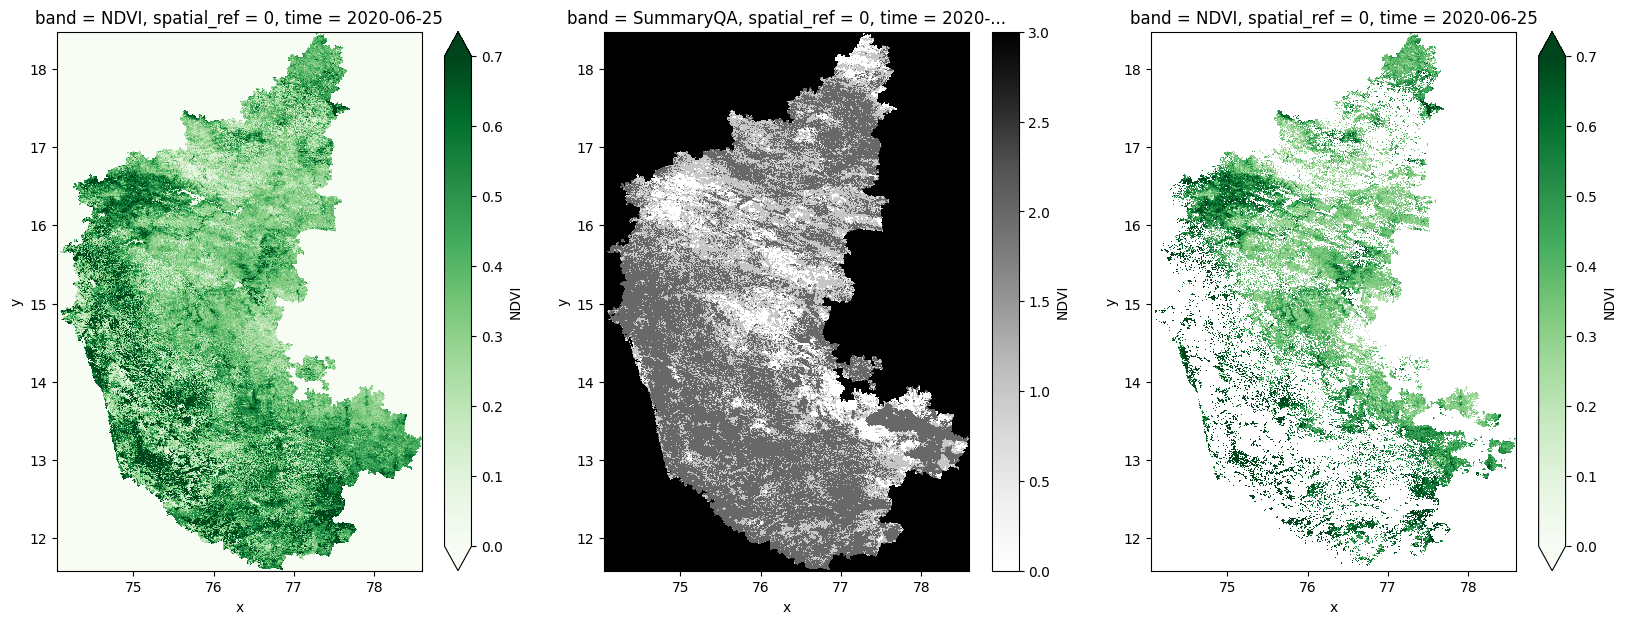

In [258]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
fig.set_size_inches(20,7)


image.sel(band='NDVI').plot.imshow(ax=ax0, vmin=0, vmax=0.7, add_colorbar=True, cmap='Greens')
image.sel(band='SummaryQA').plot.imshow(ax=ax1, vmin=0, vmax=3, add_colorbar=True, cmap='Greys')
masked.sel(band='NDVI').plot.imshow(ax=ax2, vmin=0, vmax=0.7, add_colorbar=True, cmap='Greens')

ax.set_axis_off()

plt.show()

Apply Mask on all images

In [259]:
summary_qa = time_series_scenes.sel(band='SummaryQA')
time_series_scenes_masked = time_series_scenes.sel(band=['NDVI', 'EVI']).where(summary_qa <= 1)
time_series_scenes_masked

<xarray.DataArray 'NDVI' (time: 22, band: 2, y: 1656, x: 1090)>
dask.array<where, shape=(22, 2, 1656, 1090), dtype=float64, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U10 'NDVI' 'EVI'
  * x            (x) float64 74.05 74.06 74.06 74.06 ... 78.58 78.58 78.59 78.59
  * y            (y) float64 18.48 18.47 18.47 18.46 ... 11.59 11.59 11.59 11.58
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2020-01-01 2020-01-17 ... 2020-12-18

## Plotting the time-series

We extract the time-series at a specific X,Y coordinate.

In [278]:
time_series = time_series_scenes.sel(band=['NDVI', 'EVI']).interp(y=13.16, x=77.35)

This time-series has cloudy pixels which show up as anomalous NDVI and EVI values.

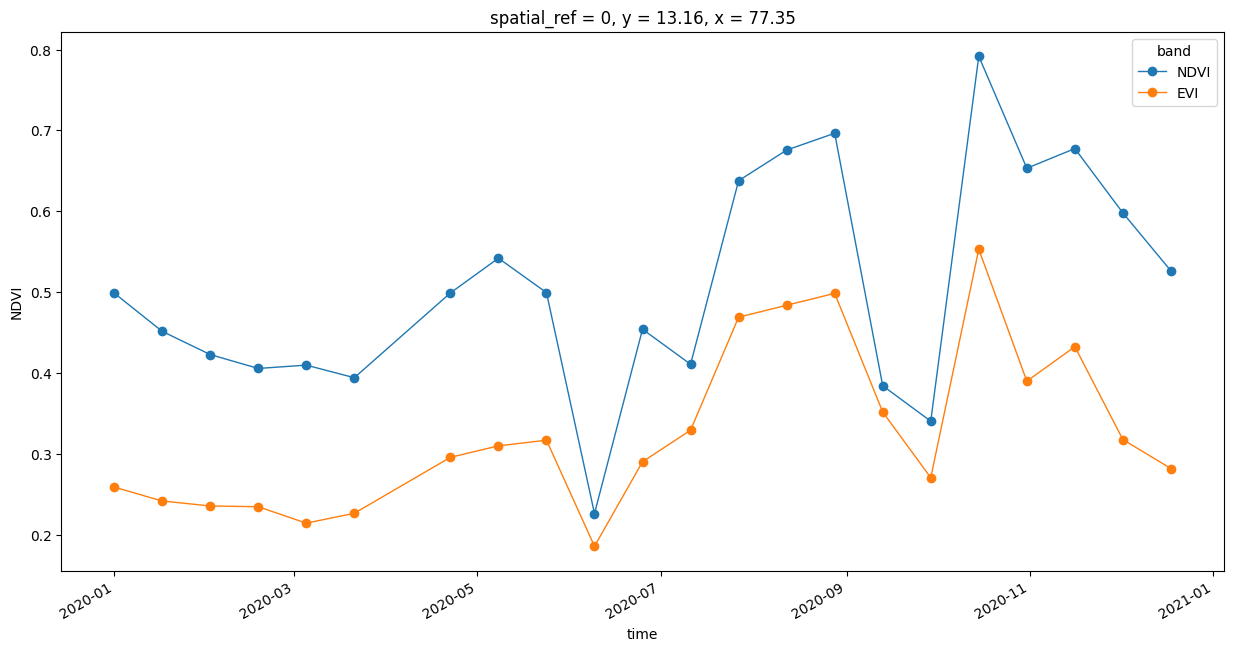

In [279]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(15, 7)
time_series.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

Let's plot the cloud-masked time-series.

In [272]:
time_series_masked = time_series_scenes_masked.sel(band=['NDVI', 'EVI']).interp(y=13.16, x=77.35)

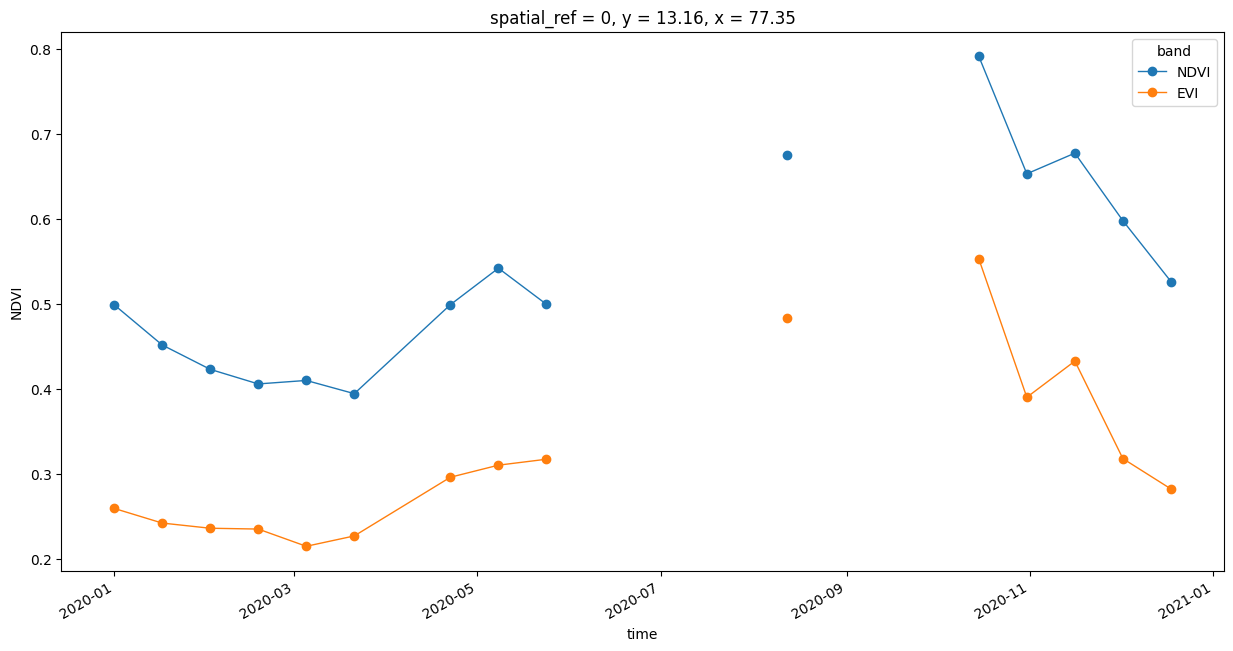

In [273]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_masked.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

This looks much better, but we have gaps in the time-series due to masked cloudy-pixels. Replace them with linearly interpolated values.

In [274]:
time_series_masked_interpolated = time_series_masked.chunk(dict(time=-1)).interpolate_na('time')

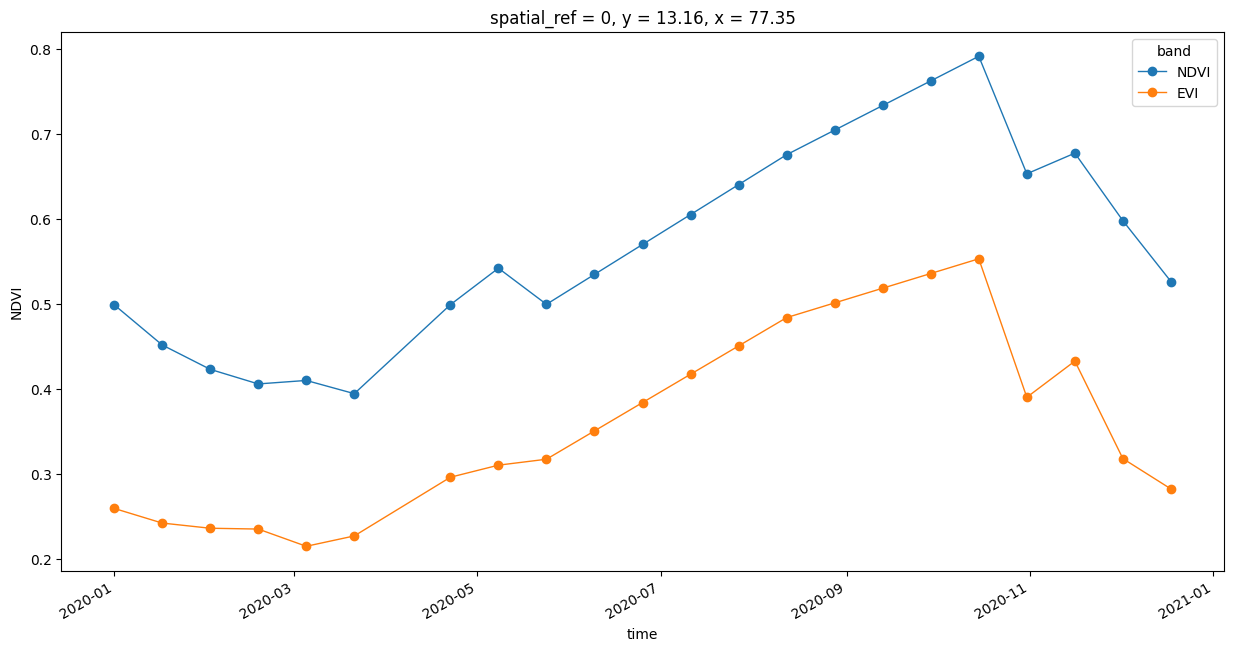

In [275]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_masked_interpolated.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

We can set the series colors to our choice of colors using Matplotlib Cycler.

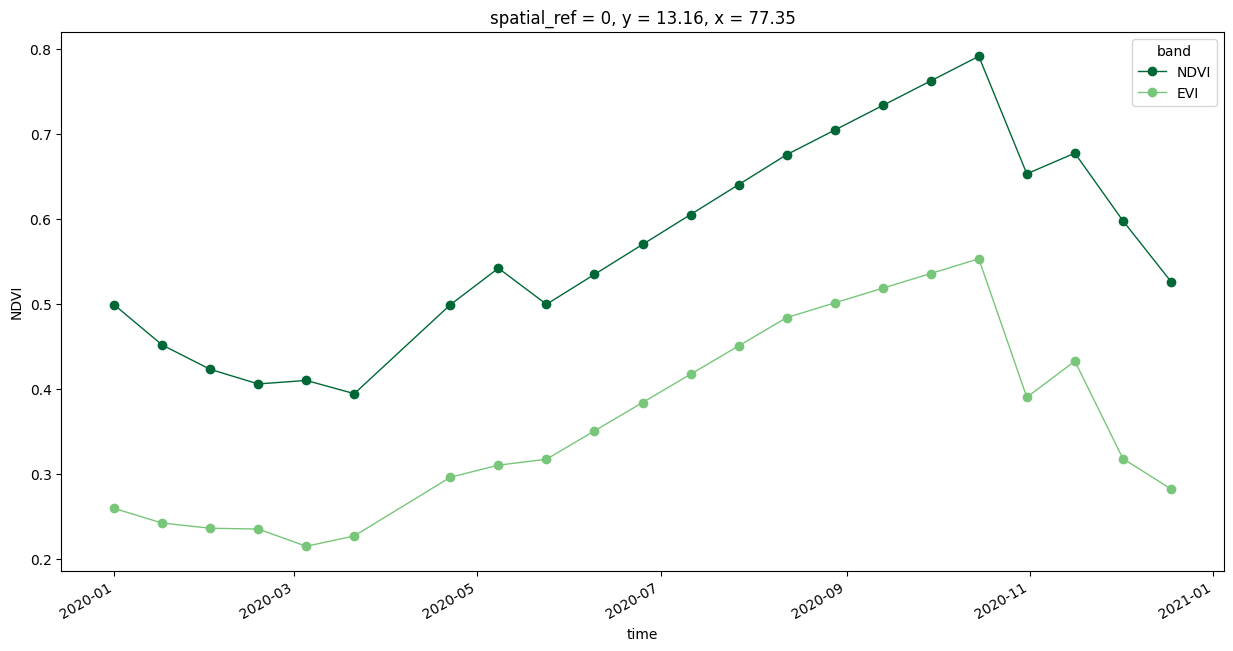

In [280]:
from cycler import cycler
import matplotlib as mpl

colorlist = ['#006837', '#78c679']
custom_cycler = cycler(color=colorlist)

fig, ax = plt.subplots(1, 1)
ax.set_prop_cycle(custom_cycler)

fig.set_size_inches(15, 7)
time_series_masked_interpolated.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

In [263]:
df = time_series_masked.to_pandas()
df = df.fillna(-9999)
df

band,NDVI,EVI
time,,
2020-01-01,0.480659,0.238432
2020-01-17,0.458003,0.220475
2020-02-02,0.403794,0.210135
2020-02-18,0.402678,0.215551
2020-03-05,0.412266,0.256845
2020-03-21,0.533341,0.342925
2020-04-22,0.554610,0.382850
2020-05-08,0.425700,0.238320
2020-05-24,0.609259,0.425442


In [264]:
output_filename = 'time_series.csv'
output_filepath = os.path.join(output_folder, output_filename)
df.reset_index().to_csv(output_filepath, index=False)